In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from collections import OrderedDict
import seaborn as sns
from PIL import Image

import os
print(os.listdir("../input/cell_images/cell_images/"))

['Uninfected', 'Parasitized']


In [78]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
                                

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


In [79]:
img_dir='../input/cell_images/cell_images/'
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

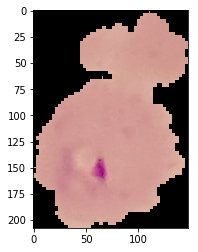

Image type: torch.FloatTensor
Image size: torch.Size([3, 208, 148])


In [80]:
# pytorch provides a function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file. Assuming it is in the same directory.
pil_image = Image.open('../input/cell_images/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png')
rgb_image = pil2tensor(pil_image)

# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))

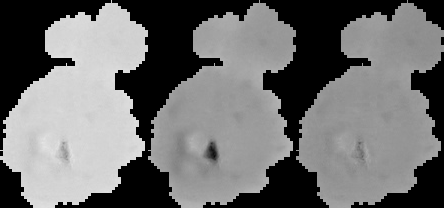

In [81]:
from io import BytesIO
import IPython.display

r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

def show_grayscale_image(tensor):
    # IPython.display can only show images from a file.
    # So we mock up an in-memory file to show it.
    # IPython.display needs a numpy array with channels first.
    # and it also has to be uint8 with values between 0 and 255.
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy()) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Cat concatenates tensors along a given dimension, we choose width here (1), instead of height (0).
show_grayscale_image(torch.cat((r_image, g_image, b_image), 1))

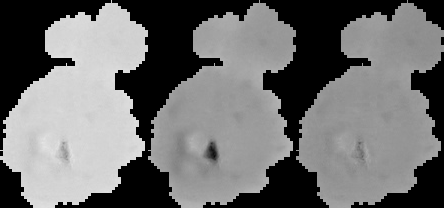

In [82]:
from io import BytesIO
import IPython.display

r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

def show_grayscale_image(tensor):
    # IPython.display can only show images from a file.
    # So we mock up an in-memory file to show it.
    # IPython.display needs a numpy array with channels first.
    # and it also has to be uint8 with values between 0 and 255.
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy()) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Cat concatenates tensors along a given dimension, we choose width here (1), instead of height (0).
show_grayscale_image(torch.cat((r_image, g_image, b_image), 1))

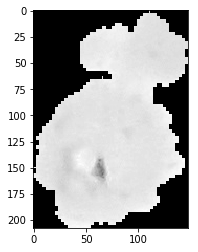

In [83]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

grayscale_image = (r_image + g_image + b_image).div(3.0)

def plot_grayscale_image(tensor):
    plt.figure()
    plt.imshow(tensor.numpy(), cmap = 'gray')
    plt.show()
    
plot_grayscale_image(grayscale_image)

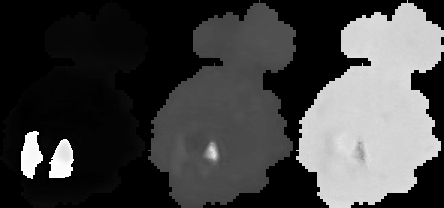

In [84]:
hsv_image = pil2tensor(pil_image.convert('HSV'))

h_image = hsv_image[0]
s_image = hsv_image[1]
v_image = hsv_image[2]

show_grayscale_image(torch.cat((h_image, s_image, v_image), 1))

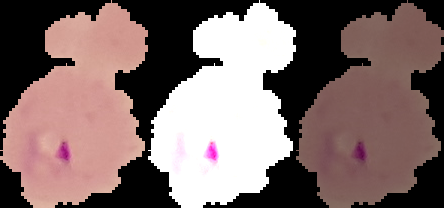

In [85]:
bright_rgb_image = rgb_image.clone()
dark_rgb_image = rgb_image.clone()

# Multiply all elements in the image by 1.8, and then clamp values between 0 and 1.
bright_rgb_image.mul_(1.8).clamp_(0, 1)

# Multiply all elements in the image by 0.6, and then clamp values between 0 and 1.
dark_rgb_image.mul_(0.6).clamp_(0, 1)

def show_image(tensor):
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy().transpose(1, 2, 0)) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Since these are color images (0: channels, 1: height, 2: width), we need to concat in the 2nd dimension. 
show_image(torch.cat((rgb_image, bright_rgb_image, dark_rgb_image), 2))

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


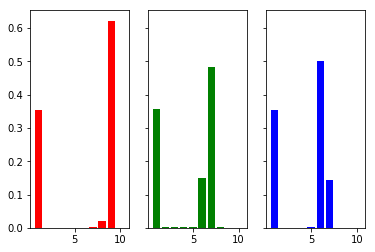

In [86]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

# Compute histograms for each channel.
hist_r = torch.histc(r_image, bins = 10, min = 0.0, max = 1.0)
hist_g = torch.histc(g_image, bins = 10, min = 0.0, max = 1.0)
hist_b = torch.histc(b_image, bins = 10, min = 0.0, max = 1.0)

# Normalize the histograms so that they sum to 1.
hist_r = hist_r.div(hist_r.sum())
hist_g = hist_g.div(hist_g.sum())
hist_b = hist_b.div(hist_b.sum())

# Plot the histograms.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
ax1.bar(np.linspace(1.0, 10.0, num = 10), hist_r.numpy(), color='r')
ax2.bar(np.linspace(1.0, 10.0, num = 10), hist_g.numpy(), color='g')
ax3.bar(np.linspace(1.0, 10.0, num = 10), hist_b.numpy(), color='b')
fig.show();

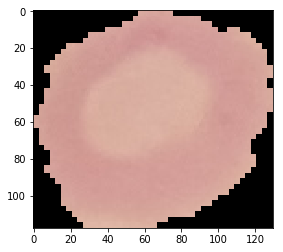

Image type: torch.FloatTensor
Image size: torch.Size([3, 118, 130])


In [87]:
# pytorch provides a function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file. Assuming it is in the same directory.
pil_image = Image.open('../input/cell_images/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_65.png')
rgb_image = pil2tensor(pil_image)

# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))

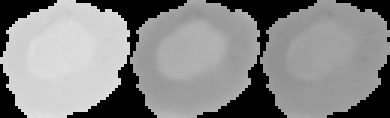

In [88]:
from io import BytesIO
import IPython.display

r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

def show_grayscale_image(tensor):
    # IPython.display can only show images from a file.
    # So we mock up an in-memory file to show it.
    # IPython.display needs a numpy array with channels first.
    # and it also has to be uint8 with values between 0 and 255.
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy()) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Cat concatenates tensors along a given dimension, we choose width here (1), instead of height (0).
show_grayscale_image(torch.cat((r_image, g_image, b_image), 1))

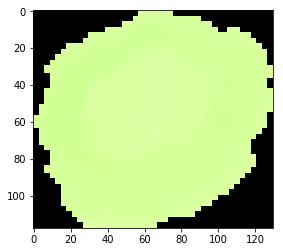

In [89]:
# We need to clone, otherwise both tensors would point to the same object, and we don't want to modify the
# original image as we want to keep working with it later. Always keep this in mind!
image_copy = rgb_image.clone()

# Multiply the green channel by two, clamp the values to the 0-1 range.
image_copy[1] = image_copy[1].mul(2.0).clamp(0.0, 1.0)

# Note: Alternatively we can accomplish the above with an in-place operations.
# Remember that in-place operations in pytorch end with _, not all operations support it.
# but often you want to prefer in-place as you don't need extra memory. See below:
#
# image_copy[1].mul_(2).clamp_(0, 1)
#

# Plot the image_copy.
plot_image(image_copy)
# Try, enhacing the other channels!

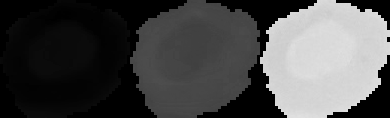

In [90]:
hsv_image = pil2tensor(pil_image.convert('HSV'))

h_image = hsv_image[0]
s_image = hsv_image[1]
v_image = hsv_image[2]

show_grayscale_image(torch.cat((h_image, s_image, v_image), 1))

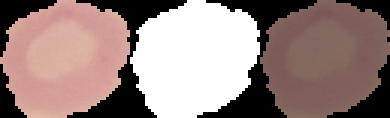

In [91]:
bright_rgb_image = rgb_image.clone()
dark_rgb_image = rgb_image.clone()

# Multiply all elements in the image by 1.8, and then clamp values between 0 and 1.
bright_rgb_image.mul_(1.8).clamp_(0, 1)

# Multiply all elements in the image by 0.6, and then clamp values between 0 and 1.
dark_rgb_image.mul_(0.6).clamp_(0, 1)

def show_image(tensor):
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy().transpose(1, 2, 0)) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Since these are color images (0: channels, 1: height, 2: width), we need to concat in the 2nd dimension. 
show_image(torch.cat((rgb_image, bright_rgb_image, dark_rgb_image), 2))

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


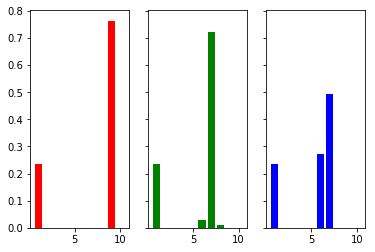

In [92]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

# Compute histograms for each channel.
hist_r = torch.histc(r_image, bins = 10, min = 0.0, max = 1.0)
hist_g = torch.histc(g_image, bins = 10, min = 0.0, max = 1.0)
hist_b = torch.histc(b_image, bins = 10, min = 0.0, max = 1.0)

# Normalize the histograms so that they sum to 1.
hist_r = hist_r.div(hist_r.sum())
hist_g = hist_g.div(hist_g.sum())
hist_b = hist_b.div(hist_b.sum())

# Plot the histograms.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
ax1.bar(np.linspace(1.0, 10.0, num = 10), hist_r.numpy(), color='r')
ax2.bar(np.linspace(1.0, 10.0, num = 10), hist_g.numpy(), color='g')
ax3.bar(np.linspace(1.0, 10.0, num = 10), hist_b.numpy(), color='b')
fig.show();

In [93]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20, 
    sampler=test_sampler, num_workers=num_workers)

5511 2756 19291


<BarContainer object of 4 artists>

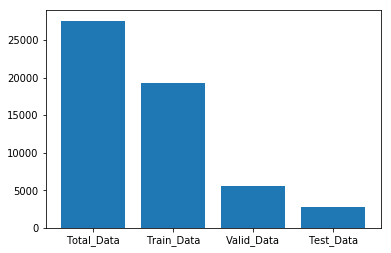

In [94]:
plt.bar(['Total_Data','Train_Data','Valid_Data','Test_Data'],[len(train_data),len(train_idx),len(valid_idx),len(test_idx)])

In [95]:
model = models.resnet50(pretrained=True,)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [97]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)

In [98]:
def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    train_correct = 0.
    train_total = 0.
    train_accuracy=[]
    
    valid_correct=0.
    valid_total=0.
    valid_accuracy=[]
    
    loss_valid=[]
    loss_train=[]
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_accuracy.append(100. * train_correct / train_total) 
            loss_train.append(train_loss)
        
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_accuracy.append(100. * valid_correct / valid_total) 
            
            loss_valid.append(valid_loss)   
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    plt.plot(train_accuracy)
    plt.plot(valid_accuracy)
    plt.title('Train Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Batch_idx')
    plt.legend(['train', 'validation'])
    plt.show()         
    
    plt.plot(loss_train)
    plt.plot(loss_valid)
    plt.title('Train Loss')
    plt.ylabel('Loss')
    plt.xlabel('Batch_idx')
    plt.legend(['train', 'validation'])
    plt.show()         
    
    print('\Train Accuracy: %4d%% (%2d/%2d)' % (
        100. * train_correct / train_total, train_correct, train_total))
    # return trained model
    return model

Epoch 1, Batch 1 loss: 0.695819
Epoch 1, Batch 101 loss: 0.522027
Epoch 1, Batch 201 loss: 0.475174
Epoch 1, Batch 301 loss: 0.452333
Epoch: 1 	Training Loss: 0.451627 	Validation Loss: 0.407937
Validation loss decreased (inf --> 0.407937).  Saving model ...
Epoch 2, Batch 1 loss: 0.334489
Epoch 2, Batch 101 loss: 0.389298
Epoch 2, Batch 201 loss: 0.388538
Epoch 2, Batch 301 loss: 0.385433
Epoch: 2 	Training Loss: 0.385577 	Validation Loss: 0.368118
Validation loss decreased (0.407937 --> 0.368118).  Saving model ...
Epoch 3, Batch 1 loss: 0.291052
Epoch 3, Batch 101 loss: 0.359407
Epoch 3, Batch 201 loss: 0.374610
Epoch 3, Batch 301 loss: 0.370310
Epoch: 3 	Training Loss: 0.370243 	Validation Loss: 0.367961
Validation loss decreased (0.368118 --> 0.367961).  Saving model ...
Epoch 4, Batch 1 loss: 0.394475
Epoch 4, Batch 101 loss: 0.373184
Epoch 4, Batch 201 loss: 0.368928
Epoch 4, Batch 301 loss: 0.369326
Epoch: 4 	Training Loss: 0.369072 	Validation Loss: 0.348582
Validation loss de

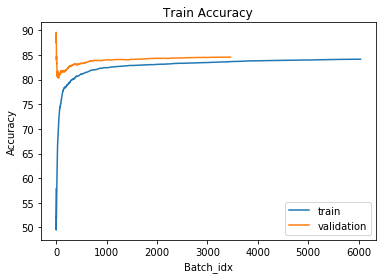

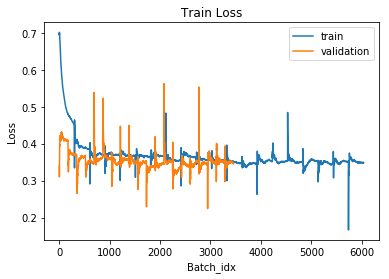

\Train Accuracy:   84% (324593/385820)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [99]:
train(20, model, optimizer, criterion, use_cuda, 'malaria_detection.pt')

In [100]:
model.load_state_dict(torch.load('malaria_detection.pt'))

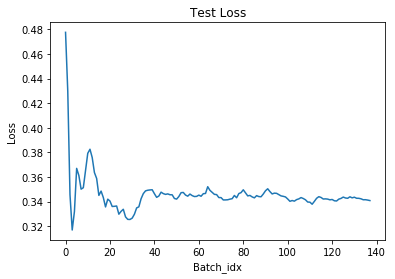

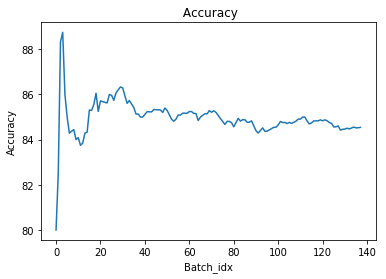

Test Loss: 0.340895


Test Accuracy:   84% (2330/2756)


In [101]:
def test(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    accuracy=[]
    loss_test=[]
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        loss_test.append(test_loss)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        accuracy.append(100. * correct / total)    
    plt.plot(loss_test)
    plt.title('Test Loss')
    plt.ylabel('Loss')
    plt.xlabel('Batch_idx')
    #plt.legend(['train', 'validation'])
    plt.show()         
    
    plt.plot(accuracy)
    plt.title(' Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Batch_idx')
    #plt.legend(['train', 'validation'])
    plt.show()    
    
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %4d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(model, criterion, use_cuda)

In [ ]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image
def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]
from glob import glob
from PIL import Image
from termcolor import colored

class_names=['Parasitized','Uninfected']
inf = np.array(glob("../input/cell_images/cell_images/Parasitized/*"))
uninf = np.array(glob("../input/cell_images/cell_images/Uninfected/*"))
for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()

In [ ]:
!!jupyter nbconvert *.ipynb